In [1]:
###################################################
# Name : Bhargey Mehta
# SID  : 201701074
# Info : Complex Networks - Project
###################################################

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Career Averages

In [2]:
def get_batting_career_avg():
    bat = pd.read_csv('batsmen_averages.csv')
    
    batsmen = np.array(bat['batsman'])
    runs = np.array(bat['total_runs'])
    innings = np.array(bat['total_innings'])
    
    avg = runs / innings
    
    bat_career_avg = {}
    for i, batsman in enumerate(batsmen):
        bat_career_avg[batsman] = avg[i]

    return bat_career_avg

def get_bowling_career_avg():
    ball = pd.read_csv('bowlers_averages.csv')
    
    bowlers = np.array(ball['bowler'])
    runs = np.array(ball['total_runs'])
    dismisses = np.array(ball['total_dismisses'])
    
    avg = runs / np.maximum(np.ones(dismisses.shape), dismisses)
    
    ball_career_avg = {}
    for i, bowler in enumerate(bowlers):
        ball_career_avg[bowler] = avg[i]

    return ball_career_avg

# PageRank

In [3]:
def get_out_strengths(G):
    out_strengths = {}
    for node in G.nodes():
        out_strengths[node] = 0
        for edge in G.out_edges(node, data=True):
            out_strengths[node] += edge[2]['weight']
    return out_strengths

def get_in_strengths(G):
    in_strengths = {}
    for node in G.nodes():
        in_strengths[node] = 0
        for edge in G.in_edges(node, data=True):
            in_strengths[node] += edge[2]['weight']
    return in_strengths

def get_D_inv(G):
    out_strengths = get_out_strengths(G)
    n = len(out_strengths)
    D_inv = np.zeros(shape=(n, n))
    for index, node in enumerate(G.nodes()):
        if out_strengths[node] == 0:
            D_inv[index][index] = 1
        else:
            D_inv[index][index] = 1 / out_strengths[node]
    return D_inv

def pageRank(A, Dinv, iters, G, q = 0.15):
    conv_history = []

    n = len(A)
    p = np.ones((n, 1)) / n
    out_str = get_out_strengths(G)

    deltaSj = np.zeros((n, 1))
    for i, node in enumerate(G.nodes()):
        if out_str[node] == 0:
            deltaSj[i] = 1

    for i in range(iters):
        pnew = (1-q) * np.matmul(np.matmul(A.transpose(), Dinv), p) + (q/n) + ((1-q)/n) * np.sum(np.multiply(p, deltaSj))
        change = np.sqrt(np.sum(np.power(p-pnew, 2)))
        conv_history.append(change)
        p = pnew / np.sum(pnew)
    
    return p, conv_history

# PIB

## PIB Graph & Projection

In [4]:
def get_PIB():
    CBo = get_bowling_career_avg()
    
    pib = {}
    for row in np.array(pd.read_csv('batsmen_against_bowlers_averages.csv')):
        batsman, bowler, runs, dismisses = row
        if batsman not in pib:
            pib[batsman] = {}
        
        aba = runs / max(1, dismisses)
        if CBo[bowler] == 0: cbo = 1
        else: cbo = CBo[bowler]
        pib[batsman][bowler] = aba / cbo
    
    return pib

def get_PIB_graph():
    G = nx.DiGraph()
    pib = get_PIB()
    for batsman in pib:
        for bowler in pib[batsman]:
            G.add_edge(bowler, batsman, weight = pib[batsman][bowler])

    return G

def get_one_mode_projected_from_PIB(pib):
    G_und = nx.Graph()
    
    for node in pib.nodes():
        out_edges = pib.out_edges(node)

        for bowler, batter_A in out_edges:
            for bowler, batter_B in out_edges:
                if batter_A != batter_B:
                    G_und.add_edge(batter_A, batter_B)
    
    in_strengths = get_in_strengths(pib)

    G = nx.DiGraph()
    for batter_A, batter_B in G_und.edges():
        in_str_A = in_strengths[batter_A]
        in_str_B = in_strengths[batter_B]
        if in_str_A < in_str_B:
            G.add_edge(batter_A, batter_B, weight = in_str_B - in_str_A)
        else:
            G.add_edge(batter_B, batter_A, weight = in_str_A - in_str_B)

    return G

## PIB Results & Ranks

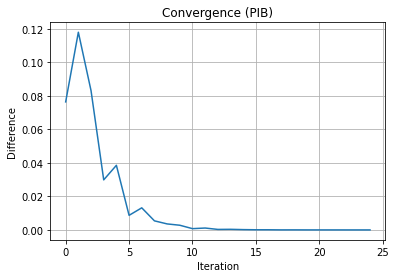

In [5]:
PIB_graph = get_PIB_graph()
PIB_proj = get_one_mode_projected_from_PIB(PIB_graph)

# this gives i->j convention
PIB_adj = nx.linalg.graphmatrix.adjacency_matrix(PIB_proj).todense()
PIB_D_inv = get_D_inv(PIB_proj)

scores, change = pageRank(PIB_adj, PIB_D_inv, 25, PIB_proj)

plt.plot(change)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.title('Convergence (PIB)')
plt.show()

In [6]:
n = len(scores)
ranks = sorted(range(n), key=lambda x: scores[x], reverse=True)
batsmen = list(PIB_proj.nodes())
for i in range(25):
    score = round(float(scores[ranks[i]]), 5)
    score = str(score).ljust(5+2, '0')
    rank = str(i+1).zfill(2)
    batter = batsmen[ranks[i]]
    print('Score {} : Rank {} : {}'.format(score, rank, batter))

Score 0.16419 : Rank 01 : AN Cook
Score 0.06060 : Rank 02 : HM Amla
Score 0.03863 : Rank 03 : LRPL Taylor
Score 0.02310 : Rank 04 : KS Williamson
Score 0.02077 : Rank 05 : AB de Villiers
Score 0.01860 : Rank 06 : JE Root
Score 0.01655 : Rank 07 : SPD Smith
Score 0.01541 : Rank 08 : V Kohli
Score 0.01458 : Rank 09 : DA Warner
Score 0.01308 : Rank 10 : MJ Clarke
Score 0.01124 : Rank 11 : KC Sangakkara
Score 0.01055 : Rank 12 : AD Mathews
Score 0.00976 : Rank 13 : Azhar Ali
Score 0.00881 : Rank 14 : CA Pujara
Score 0.00874 : Rank 15 : EA Perry
Score 0.00784 : Rank 16 : Younis Khan
Score 0.00736 : Rank 17 : S Chanderpaul
Score 0.00660 : Rank 18 : IR Bell
Score 0.00642 : Rank 19 : BB McCullum
Score 0.00616 : Rank 20 : KP Pietersen
Score 0.00594 : Rank 21 : Mushfiqur Rahim
Score 0.00562 : Rank 22 : HC Knight
Score 0.00552 : Rank 23 : Tamim Iqbal
Score 0.00540 : Rank 24 : GC Smith
Score 0.00526 : Rank 25 : Misbah-ul-Haq


# QIB

## QIB Graph & Projection

In [7]:
def get_QIB():
    CBa = get_batting_career_avg()
    CBo = get_bowling_career_avg()
    
    qib = {}
    for row in np.array(pd.read_csv('batsmen_against_bowlers_averages.csv')):
        batsman, bowler, runs, dismisses = row
        if bowler not in qib:
            qib[bowler] = {}
        
        cba = CBa[batsman]
        if CBo[bowler] == 0: cbo = 1
        else: cbo = CBo[bowler]
        d = dismisses
        
        qib[bowler][batsman] = d * (cba / cbo)
    
    return qib

def get_QIB_graph():
    G = nx.DiGraph()
    qib = get_QIB()
    for bowler in qib:
        for batsman in qib[bowler]:
            G.add_edge(batsman, bowler, weight = qib[bowler][batsman])

    return G

def get_one_mode_projected_from_QIB(qib):
    G_und = nx.Graph()

    for node in qib.nodes():
        out_edges = qib.out_edges(node)

        for batter, bowler_A in out_edges:
            for batter, bowler_B in out_edges:
                if bowler_A != bowler_B:
                    G_und.add_edge(bowler_A, bowler_B)
    
    in_strengths = get_in_strengths(qib)

    G = nx.DiGraph()
    for bowler_A, bowler_B in G_und.edges():
        in_str_A = in_strengths[bowler_A]
        in_str_B = in_strengths[bowler_B]
        if in_str_A < in_str_B:
            G.add_edge(bowler_A, bowler_B, weight = in_str_B - in_str_A)
        else:
            G.add_edge(bowler_B, bowler_A, weight = in_str_A - in_str_B)

    return G

## QIB Results & Ranks

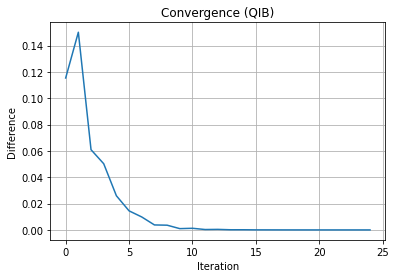

In [8]:
QIB_graph = get_QIB_graph()
QIB_proj = get_one_mode_projected_from_QIB(QIB_graph)

# this gives i->j convention
QIB_adj = nx.linalg.graphmatrix.adjacency_matrix(QIB_proj).todense()
QIB_D_inv = get_D_inv(QIB_proj)

scores, change = pageRank(QIB_adj, QIB_D_inv, 25, QIB_proj)

plt.plot(change)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.title('Convergence (QIB)')
plt.show()

In [9]:
n = len(scores)
ranks = sorted(range(n), key=lambda x: scores[x], reverse=True)
bowlers = list(QIB_proj.nodes())
for i in range(25):
    score = round(float(scores[ranks[i]]), 5)
    score = str(score).ljust(5+2, '0')
    rank = str(i+1).zfill(2)
    bowler = bowlers[ranks[i]]
    print('Score {} : Rank {} : {}'.format(score, rank, bowler))

Score 0.18766 : Rank 01 : JM Anderson
Score 0.08336 : Rank 02 : SCJ Broad
Score 0.04235 : Rank 03 : DW Steyn
Score 0.02799 : Rank 04 : HMRKB Herath
Score 0.02666 : Rank 05 : R Ashwin
Score 0.02128 : Rank 06 : NM Lyon
Score 0.01844 : Rank 07 : M Morkel
Score 0.01550 : Rank 08 : MG Johnson
Score 0.01200 : Rank 09 : VD Philander
Score 0.01184 : Rank 10 : TG Southee
Score 0.01066 : Rank 11 : TA Boult
Score 0.01062 : Rank 12 : I Sharma
Score 0.00947 : Rank 13 : GP Swann
Score 0.00922 : Rank 14 : MA Starc
Score 0.00844 : Rank 15 : K Rabada
Score 0.00829 : Rank 16 : EA Perry
Score 0.00763 : Rank 17 : RA Jadeja
Score 0.00746 : Rank 18 : PM Siddle
Score 0.00719 : Rank 19 : N Wagner
Score 0.00700 : Rank 20 : JR Hazlewood
Score 0.00696 : Rank 21 : KAJ Roach
Score 0.00636 : Rank 22 : JL Gunn
Score 0.00563 : Rank 23 : PJ Cummins
Score 0.00545 : Rank 24 : Yasir Shah
Score 0.00523 : Rank 25 : Shakib Al Hasan


# Unweighted Undirected BPN

In [10]:
def get_unweighted_BPN(country='india'):
    file_name = 'partnership_' + country + '.csv'
    data = pd.read_csv(file_name)
    
    G = nx.Graph()
    for striker, non_striker in zip(data['striker'], data['non_striker']):
        G.add_edge(striker, non_striker)

    return G

## Degree Distribution

In [11]:
def display_degree_distribution(country):
    bpn = get_unweighted_BPN(country)
    degrees = bpn.degree()
    degrees = [x[1] for x in degrees]
    degree_count = {}
    for d in degrees:
        if d not in degree_count:
            degree_count[d] = 0
        degree_count[d] += 1

    d = []
    f = []
    for k in sorted(degree_count.keys()):
        d.append(k)
        f.append(degree_count[k])

    plt.plot(d, f)

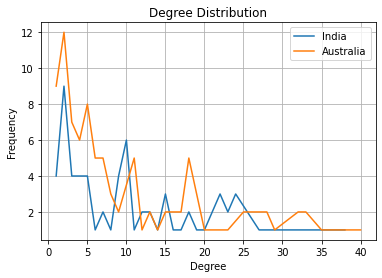

In [12]:
display_degree_distribution('india')
display_degree_distribution('australia')
plt.grid()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.legend(['India', 'Australia'])
plt.show()

## Clustering Coefficient

In [14]:
def get_clustering_coeffs(country, need_object=False):
    bpn = get_unweighted_BPN(country)
    coeffs = {}
    avg_ci = 0
    for node in bpn.nodes():
        neighbors = list(bpn.neighbors(node))
        subgraph = bpn.subgraph(neighbors)
        edge_count = len(subgraph.edges())
        k = len(neighbors)
        kc2 = (k * (k-1)) // 2

        if kc2 == 0:
            continue    
        coeffs[node] = edge_count / kc2
        avg_ci += coeffs[node]

    avg_ci /= len(coeffs)

    m = len(bpn.edges())
    n = len(bpn.nodes())
    density = 2 * m / (n * (n-1))

    if need_object:
        return coeffs, avg_ci

    print('Average Clustering Coefficient, {}\t: {}'.format(country, avg_ci))
    print('Density, {}\t\t\t\t: {}'.format(country, density))

### India

In [15]:
get_clustering_coeffs('india')

Average Clustering Coefficient, india	: 0.6338067955937241
Density, india				: 0.17774936061381075


### Australia

In [16]:
get_clustering_coeffs('australia')

Average Clustering Coefficient, australia	: 0.6815207810237927
Density, australia				: 0.11732456140350878


## Betweenness Centrality

In [17]:
def get_betweenness_centrality(country, need_object=False):
    bpn = get_unweighted_BPN(country)
    x = nx.algorithms.betweenness_centrality(bpn)
    centralities = []
    for k in x:
        centralities.append((x[k], k))
    centralities.sort(reverse=True)

    if need_object:
        return centralities

    for rank, cent in enumerate(centralities[:10], 1):
        centrality, batter = cent
        print('Rank {}: {}'.format(str(rank).zfill(2), batter))
        #print('Degree: {}'.format(len(list(bpn.neighbors(batter)))))

### India

In [18]:
get_betweenness_centrality('india')

Rank 01: I Sharma
Rank 02: V Kohli
Rank 03: R Ashwin
Rank 04: MS Dhoni
Rank 05: CA Pujara
Rank 06: VVS Laxman
Rank 07: Mohammed Shami
Rank 08: AM Rahane
Rank 09: UT Yadav
Rank 10: R Dravid


### Australia

In [19]:
get_betweenness_centrality('australia')

Rank 01: MG Johnson
Rank 02: SPD Smith
Rank 03: MJ Clarke
Rank 04: NM Lyon
Rank 05: MEK Hussey
Rank 06: BJ Haddin
Rank 07: MA Starc
Rank 08: PM Siddle
Rank 09: DA Warner
Rank 10: NM Hauritz


## Closeness Centrality

In [20]:
def get_closeness_centrality(country, need_object=False):
    bpn = get_unweighted_BPN(country)
    x = nx.algorithms.closeness_centrality(bpn)
    centralities = []
    for k in x:
        centralities.append((x[k], k))
    centralities.sort(reverse=True)

    if need_object:
        return centralities

    for rank, cent in enumerate(centralities[:10], 1):
        centrality, batter = cent
        print('Rank {}: {}'.format(str(rank).zfill(2), batter))
        #print('Degree: {}'.format(len(list(bpn.neighbors(batter)))))

### India

In [21]:
get_closeness_centrality('india')

Rank 01: V Kohli
Rank 02: I Sharma
Rank 03: CA Pujara
Rank 04: MS Dhoni
Rank 05: R Ashwin
Rank 06: VVS Laxman
Rank 07: AM Rahane
Rank 08: RA Jadeja
Rank 09: R Dravid
Rank 10: Z Khan


### Australia

In [22]:
get_closeness_centrality('australia')

Rank 01: SPD Smith
Rank 02: MJ Clarke
Rank 03: MG Johnson
Rank 04: BJ Haddin
Rank 05: NM Lyon
Rank 06: PM Siddle
Rank 07: MEK Hussey
Rank 08: MA Starc
Rank 09: SE Marsh
Rank 10: MS Wade


## Assortativity

In [23]:
def get_assortativity(country):
    bpn = get_unweighted_BPN(country)
    n = len(list(bpn.nodes()))
    m = len(list(bpn.edges()))

    e = np.zeros((n, n))
    for b1, b2 in bpn.edges():
        d1 = len(list(bpn.neighbors(b1)))
        d2 = len(list(bpn.neighbors(b2)))

        e[d1-1][d2-1] += 1
        e[d2-1][d1-1] += 1
    e = e / (2*m)

    q = np.sum(e, axis=0)
    qjqk = np.matmul(np.reshape(q, (n, 1)), np.reshape(q, (1, n)))

    k = np.array(np.arange(n))
    jk = np.array([j*k for j in np.arange(n)])

    sigma2 = np.sum(np.power(k, 2) * q) - np.power(np.sum(k * q), 2)
    A = np.sum(np.multiply(jk, e-qjqk)) / sigma2

    return A

### India

In [24]:
A = get_assortativity('india')
print('Assortativity A (India): {}'.format(A))

Assortativity A (India): -0.1276916166753366


### Australia

In [25]:
A = get_assortativity('australia')
print('Assortativity A (Australia): {}'.format(A))

Assortativity A (Australia): -0.03183112642377363


## Modularity Maximization

In [26]:
def get_modularity_communities(country, need_object=False):
    bpn = get_unweighted_BPN(country)
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(bpn)
    communities = [sorted(community) for community in communities]

    if need_object:
        return communities

    for index, community in enumerate(communities, 1):
        print('Community {}'.format(index))
        for batter in community:
            print(batter)
        print()

In [27]:
def get_modularity(country):
    bpn = get_unweighted_BPN(country)
    m = len(bpn.edges())
    n = len(bpn.nodes())

    batter = [batter for batter, degree in bpn.degree()]
    degree = [degree for batter, degree in bpn.degree()]

    A = np.array(nx.linalg.graphmatrix.adjacency_matrix(bpn).todense())

    communities = get_modularity_communities(country, need_object=True)

    Q = 0
    for i in range(n):
        for j in range(n):
            delta = 0
            for community in communities:
                if batter[i] in community and batter[j] in community:
                    delta = 1
                    break
            Q += (A[i][j] - degree[i]*degree[j]/(2*m)) * delta

    Q = Q / (2*m)

    return Q

### India

In [28]:
Q = get_modularity('india')
print('Modularity (India): {}'.format(Q))

Modularity (India): 0.2945557223286111


### Australia

In [29]:
Q = get_modularity('australia')
print('Modularity (Australia): {}'.format(Q))

Modularity (Australia): 0.31732553061402863


## Community Structure (Z-score)

In [30]:
def get_community_structure(country, need_object=False):
    bpn = get_unweighted_BPN(country)
    communities = get_modularity_communities(country, need_object=True)
    communities = [set(community) for community in communities]

    Z = []
    P = []
    ki = []
    mean_ksi = []
    sigma_ksi = []
    for index, community in enumerate(communities):
        ki.append({})
        Z.append({})
        P.append({})
        
        for batter in community:
            batter_neighbors = set(bpn.neighbors(batter))
            ki[index][batter] = len(community.intersection(batter_neighbors))
        
        ksi_av = np.mean(list(ki[index].values()))
        ksi_std = np.std(list(ki[index].values()))
        mean_ksi.append(ksi_av)
        sigma_ksi.append(ksi_std)

        for batter in community:
            Z[index][batter] = (ki[index][batter] - mean_ksi[index]) / sigma_ksi[index]
            
            batter_neighbors = set(bpn.neighbors(batter))
            kis = list(map(lambda x: len(x & batter_neighbors), communities))
            kis = np.array(kis)
            
            P[index][batter] = 1 - np.sum(np.power(kis / len(batter_neighbors), 2))

    if need_object:
        return Z, P

    print('Batter \t\t: Zi \t: Pi')
    for z_c, p_c, i in zip(Z, P, range(len(Z))):
        print('Community {}:'.format(i+1))
        for batter in z_c:
            zprint = str(round(z_c[batter], 5)).ljust(8, '0')
            pprint = str(round(p_c[batter], 5)).ljust(8, '0')
            bprint = batter.ljust(15)
            print('{} : {} : {}'.format(bprint, zprint, pprint))
        print()

### India

In [31]:
get_community_structure('india')

Batter 		: Zi 	: Pi
Community 1:
GH Vihari       : -0.14847 : 0.165290
SN Thakur       : -1.52929 : 0.000000
VR Aaron        : -0.60875 : 0.420000
R Ashwin        : 1.385770 : 0.444440
PA Patel        : -0.76217 : 0.444440
NV Ojha         : -1.37587 : 0.444440
WP Saha         : 0.925490 : 0.385630
PP Shaw         : -1.06902 : 0.000000
HH Pandya       : 0.311800 : 0.231110
RR Pant         : 0.158370 : 0.142010
RA Jadeja       : 1.385770 : 0.277780
AM Rahane       : 1.232340 : 0.417010
Mohammed Shami  : 1.078920 : 0.340260
S Nadeem        : -1.37587 : 0.000000
STR Binny       : 0.004950 : 0.260360
UT Yadav        : 1.232340 : 0.235540
KV Sharma       : -1.06902 : 0.320000
B Kumar         : 0.004950 : 0.336730
RG Sharma       : 0.772070 : 0.265930
J Yadav         : -0.91559 : 0.277780
KK Nair         : -0.45532 : 0.000000
MA Agarwal      : -0.30190 : 0.000000
Kuldeep Yadav   : -0.91559 : 0.000000
CA Pujara       : 1.692610 : 0.466940
M Vijay         : 0.158370 : 0.444440
A Mukund        :

### Australia

In [32]:
get_community_structure('australia')

Batter 		: Zi 	: Pi
Community 1:
UT Khawaja      : 1.000690 : 0.471940
JL Pattinson    : 0.058220 : 0.498610
JM Bird         : -0.74961 : 0.406250
JW Hastings     : -1.28817 : 0.444440
CT Bancroft     : -0.74961 : 0.000000
MS Harris       : -0.61497 : 0.000000
AC Agar         : -1.01889 : 0.444440
SE Marsh        : 1.269970 : 0.498050
AJ Finch        : -0.61497 : 0.000000
JM Holland      : -1.01889 : 0.000000
MC Henriques    : -0.34569 : 0.297520
CJ Ferguson     : -1.42281 : 0.000000
JA Richardson   : -1.42281 : 0.000000
NJ Maddinson    : -1.15353 : 0.000000
JM Mennie       : -1.42281 : 0.000000
PM Nevill       : 0.192860 : 0.320310
KR Patterson    : -0.88425 : 0.000000
MT Renshaw      : -0.07642 : 0.000000
SNJ O'Keefe     : -0.34569 : 0.000000
HWR Cartwright  : -1.28817 : 0.000000
SPD Smith       : 1.943170 : 0.485000
TD Paine        : 0.596780 : 0.460800
NM Lyon         : 1.673890 : 0.475310
CJ Sayers       : -1.28817 : 0.000000
PJ Cummins      : 0.866060 : 0.099720
MR Marsh        :

## Community Roles

In [33]:
def get_community_roles(Z, P, need_object=False):
    classified_roles = {
            'non-hubs': {
                'ultra-peripheral': {},
                'peripheral': {},
                'connector': {},
                'kinless': {}
            },
            'hubs': {
                'provincial': {},
                'connector': {},
                'kinless': {}
            }
        }
    for index, comm_p, comm_z in zip(range(len(P)), P, Z):
        for batter in comm_p:
            p = comm_p[batter]
            z = comm_z[batter]

            if z <= 2.5:
                if p <= 0.05:
                    classified_roles['non-hubs']['ultra-peripheral'][batter] = (z, p)
                elif p <= 0.62:
                    classified_roles['non-hubs']['peripheral'][batter] = (z, p)
                elif p <= 0.8:
                    classified_roles['non-hubs']['connector'][batter] = (z, p)
                else:
                    classified_roles['non-hubs']['kinless'][batter] = (z, p)
            else:
                if p <= 0.3:
                    classified_roles['hubs']['provincial'][batter] = (z, p)
                elif p <= 0.75:
                    classified_roles['hubs']['connector'][batter] = (z, p)
                else:
                    classified_roles['hubs']['kinless'][batter] = (z, p)
    
    if need_object:
        return classified_roles

    for node_type in classified_roles:
        print(node_type.upper())
        for sub_type in classified_roles[node_type]:
            title = '|{} {}'.format(sub_type.upper(), len(classified_roles[node_type][sub_type])).ljust(38)+'|'
            print('-' * 39)
            print(title)
            for batter in classified_roles[node_type][sub_type]:
                zprint = str(round(classified_roles[node_type][sub_type][batter][0], 5)).ljust(8)
                pprint = str(round(classified_roles[node_type][sub_type][batter][1], 5)).ljust(8)
                bprint = batter.ljust(15)
                print('|{} : {} : {}|'.format(bprint, zprint, pprint))
            print()
        print('-' * 39)

### India

In [39]:
z, p = get_community_structure('india', need_object=True)
get_community_roles(z, p)

NON-HUBS
---------------------------------------
|ULTRA-PERIPHERAL 28                  |
|SN Thakur       : -1.52929 : 0.0     |
|PP Shaw         : -1.06902 : 0.0     |
|S Nadeem        : -1.37587 : 0.0     |
|KK Nair         : -0.45532 : 0.0     |
|MA Agarwal      : -0.3019  : 0.0     |
|Kuldeep Yadav   : -0.91559 : 0.0     |
|Pankaj Singh    : -1.06902 : 0.0     |
|KL Rahul        : 0.92549  : 0.0     |
|A Mithun        : -0.85188 : 0.0     |
|P Kumar         : -0.53019 : 0.0     |
|RP Singh        : -0.53019 : 0.0     |
|S Sreesanth     : -0.04766 : 0.0     |
|MM Patel        : -1.33442 : 0.0     |
|SC Ganguly      : 0.75657  : 0.0     |
|JD Unadkat      : -1.33442 : 0.0     |
|IK Pathan       : -0.04766 : 0.0     |
|W Jaffer        : -1.01273 : 0.0     |
|N Niranjana     : -0.19426 : 0.0     |
|PG Raut         : -0.19426 : 0.0     |
|M Raj           : 1.94257  : 0.0     |
|S Mandhana      : 0.87416  : 0.0     |
|E Bisht         : -1.26267 : 0.0     |
|H Kaur          : 0.87416  : 0

### Australia

In [40]:
z, p = get_community_structure('australia', need_object=True)
get_community_roles(z, p)

NON-HUBS
---------------------------------------
|ULTRA-PERIPHERAL 50                  |
|CT Bancroft     : -0.74961 : 0.0     |
|MS Harris       : -0.61497 : 0.0     |
|AJ Finch        : -0.61497 : 0.0     |
|JM Holland      : -1.01889 : 0.0     |
|CJ Ferguson     : -1.42281 : 0.0     |
|JA Richardson   : -1.42281 : 0.0     |
|NJ Maddinson    : -1.15353 : 0.0     |
|JM Mennie       : -1.42281 : 0.0     |
|KR Patterson    : -0.88425 : 0.0     |
|MT Renshaw      : -0.07642 : 0.0     |
|SNJ O'Keefe     : -0.34569 : 0.0     |
|HWR Cartwright  : -1.28817 : 0.0     |
|CJ Sayers       : -1.28817 : 0.0     |
|TM Head         : 0.46214  : 0.0     |
|M Labuschagne   : 0.73142  : 0.0     |
|PSP Handscomb   : 0.86606  : 0.0     |
|BE McGain       : -0.94045 : 0.0     |
|A Symonds       : 0.81624  : 0.0     |
|PR George       : -0.94045 : 0.0     |
|BJ Hodge        : -0.78075 : 0.0     |
|B Lee           : 0.97594  : 0.0     |
|B Casson        : -0.94045 : 0.0     |
|SW Tait         : -1.10015 : 0

# Weighted Directed BPN

In [35]:
def get_weighted_BPN(country='india'):
    file_name = 'partnership_' + country + '.csv'
    data = pd.read_csv(file_name)
    
    partnership_data = {}
    for striker, non_striker, runs in zip(data['striker'], data['non_striker'], data['runs']):
        forward = striker + '-' + non_striker
        backward = non_striker + '-' + striker
        if forward not in partnership_data:
            partnership_data[forward] = 0
            partnership_data[backward] = 0
        partnership_data[forward] += runs
        partnership_data[backward] += runs
        
    G = nx.DiGraph()
    for striker, non_striker, runs in zip(data['striker'], data['non_striker'], data['runs']):
        forward = striker + '-' + non_striker
        n_striker = runs / max(1, partnership_data[forward])
        G.add_edge(non_striker, striker, weight=n_striker)

    return G

## BPN PageRank

In [36]:
def BPN_PageRank(country):
    BPN_graph = get_weighted_BPN(country)

    # this gives i->j convention
    BPN_adj = nx.linalg.graphmatrix.adjacency_matrix(BPN_graph).todense()
    BPN_D_inv = get_D_inv(BPN_graph)

    scores, change = pageRank(BPN_adj, BPN_D_inv, 25, BPN_graph)

    plt.plot(change)
    plt.grid()
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.title('Convergence (BPN, {})'.format(country))
    plt.show()

    n = len(scores)
    ranks = sorted(range(n), key=lambda x: scores[x], reverse=True)
    batsmen = list(BPN_graph.nodes())
    for i in range(25):
        score = round(float(scores[ranks[i]]), 5)
        score = str(score).ljust(5+2, '0')
        rank = str(i+1).zfill(2)
        batter = batsmen[ranks[i]]
        print('Score {} : Rank {} : {}'.format(score, rank, batter))

### India

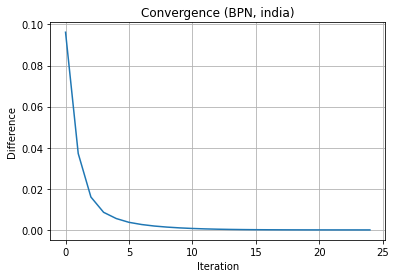

Score 0.04193 : Rank 01 : V Kohli
Score 0.03853 : Rank 02 : CA Pujara
Score 0.03607 : Rank 03 : MS Dhoni
Score 0.03192 : Rank 04 : VVS Laxman
Score 0.03151 : Rank 05 : SR Tendulkar
Score 0.03133 : Rank 06 : AM Rahane
Score 0.02975 : Rank 07 : R Ashwin
Score 0.02808 : Rank 08 : M Raj
Score 0.02590 : Rank 09 : Harbhajan Singh
Score 0.02449 : Rank 10 : RA Jadeja
Score 0.02416 : Rank 11 : R Dravid
Score 0.02404 : Rank 12 : KL Rahul
Score 0.02359 : Rank 13 : I Sharma
Score 0.02323 : Rank 14 : A Mishra
Score 0.02284 : Rank 15 : S Pandey
Score 0.02225 : Rank 16 : RG Sharma
Score 0.02203 : Rank 17 : Z Khan
Score 0.02190 : Rank 18 : S Mandhana
Score 0.02098 : Rank 19 : V Sehwag
Score 0.02005 : Rank 20 : M Vijay
Score 0.01872 : Rank 21 : WP Saha
Score 0.01777 : Rank 22 : G Gambhir
Score 0.01697 : Rank 23 : RR Pant
Score 0.01582 : Rank 24 : N Niranjana
Score 0.01577 : Rank 25 : Mohammed Shami


In [37]:
BPN_PageRank('india')

### Australia

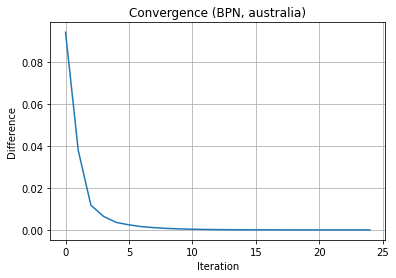

Score 0.03211 : Rank 01 : MJ Clarke
Score 0.03124 : Rank 02 : SPD Smith
Score 0.03092 : Rank 03 : MG Johnson
Score 0.02763 : Rank 04 : BJ Haddin
Score 0.02679 : Rank 05 : MEK Hussey
Score 0.02501 : Rank 06 : MA Starc
Score 0.02391 : Rank 07 : SE Marsh
Score 0.02366 : Rank 08 : JL Jonassen
Score 0.02340 : Rank 09 : PM Siddle
Score 0.02163 : Rank 10 : UT Khawaja
Score 0.02160 : Rank 11 : MS Wade
Score 0.02152 : Rank 12 : DA Warner
Score 0.02078 : Rank 13 : SR Watson
Score 0.01984 : Rank 14 : NM Lyon
Score 0.01929 : Rank 15 : AJ Blackwell
Score 0.01863 : Rank 16 : EA Perry
Score 0.01788 : Rank 17 : TD Paine
Score 0.01788 : Rank 18 : MR Marsh
Score 0.01722 : Rank 19 : BL Mooney
Score 0.01694 : Rank 20 : AJ Healy
Score 0.01682 : Rank 21 : RT Ponting
Score 0.01594 : Rank 22 : CJL Rogers
Score 0.01446 : Rank 23 : NM Hauritz
Score 0.01426 : Rank 24 : AC Voges
Score 0.01423 : Rank 25 : PSP Handscomb


In [38]:
BPN_PageRank('australia')